# 1. 폴더 정리

* 제공해드린 animals10.zip의 압축을 풀어 그 내용을 살펴보시고, 폴더 구조를 학습에 알맞도록 재구성해주세요
* 특히 각 클래스마다 약 30% 정도의 이미지를 test 폴더에 할당해주세요
* 중간중간 헷갈리다면 이것저것 확인하는 코드를 거쳐보세요 (ex. flat_test[:5]로 앞의 다섯값 확인)
* 궁금한 점이 있을 경우, 슬랙 질문 채널 활용을 적극 권장합니다.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import glob
import shutil
import torch

In [3]:
### Guideline for convenience ###
# 압축 풀기
!unzip -qq "/content/drive/MyDrive/Colab Notebooks/CNN/animals10.zip"

In [4]:
# 각 클래스별 파일 개수 확인 -> 변수로 해당 개수 저장
# Tip) 클래스가 10개이므로 각 클래스마다 똑같은 내용의 코드를 계속 써야할까요? 클래스 이름을 리스트로 저장해 for문을 돌리면서 코드를 재사용하는건 어떨까요?
path = "./Animals-10"
AnimalList = os.listdir(path)

ani_dic = {}
for c in AnimalList:
  x = sorted(glob.glob(f'./Animals-10/{c}/*'))
  ani_dic[c] = [x, len(x)]

In [5]:
# test에 넣을 이미지 개수 계산
test_count_dic = {}
for c in AnimalList:
  test_count_dic[c] = round(ani_dic[c][1]*0.3)

test_count_dic

{'squirrel': 559,
 'cat': 500,
 'elephant': 434,
 'spider': 1446,
 'horse': 787,
 'butterfly': 634,
 'chicken': 929,
 'cow': 560,
 'dog': 1459,
 'sheep': 546}

In [6]:
# train, test 폴더 경로 선언 & 만들기
path_dic = {}
for c in AnimalList:
  path_dic[f'{c}_train'] = f'./train/{c}'
  path_dic[f'{c}_test'] = f'./test/{c}'
  os.makedirs(path_dic[f'{c}_train'], exist_ok=True)
  os.makedirs(path_dic[f'{c}_test'], exist_ok=True)

In [7]:
import random

def split(img_list, test_count, train_path, test_path):
  # img_list : 이미지 경로 리스트
  # test_count : test에 할당할 이미지 개수
  # train_path : train 데이터 넣을 경로
  # test_path : test 데이터 넣을 경로
  
  # 랜덤으로 test_count만큼 이미지 img_list에서 고르기
  # test 담을 이미지 리스트 저장
  test_files=[]
  for i in random.sample(img_list, test_count):
    test_files.append(i)

  # 위에서 고르지 않은 이미지들을 train 담을 이미지 리스트로 저장
  train_files = [x for x in img_list if x not in test_files]

  # 고른 이미지를 train_path, test_path폴더에 폭사
  for k in train_files:
    shutil.copy(k, train_path)
  
  for c in test_files:
    shutil.copy(c, test_path)

  print('train 폴더 이미지 개수 : {}\ntest 폴더 이미지 개수 : {}'.format(len(glob.glob(train_path+'/*')),len(glob.glob(test_path+'/*'))))

In [8]:
# train, test 폴더로 이미지 split해서 알맞게 집어넣기
for c in AnimalList:
  split(ani_dic[c][0], test_count_dic[c], path_dic[f'{c}_train'], path_dic[f'{c}_test'])

train 폴더 이미지 개수 : 1303
test 폴더 이미지 개수 : 559
train 폴더 이미지 개수 : 1168
test 폴더 이미지 개수 : 500
train 폴더 이미지 개수 : 1012
test 폴더 이미지 개수 : 434
train 폴더 이미지 개수 : 3375
test 폴더 이미지 개수 : 1446
train 폴더 이미지 개수 : 1836
test 폴더 이미지 개수 : 787
train 폴더 이미지 개수 : 1478
test 폴더 이미지 개수 : 634
train 폴더 이미지 개수 : 2169
test 폴더 이미지 개수 : 929
train 폴더 이미지 개수 : 1306
test 폴더 이미지 개수 : 560
train 폴더 이미지 개수 : 3404
test 폴더 이미지 개수 : 1459
train 폴더 이미지 개수 : 1274
test 폴더 이미지 개수 : 546


# 2. CNN 모델
수업 코드에 '모델 성능에 대한 고민!!' 부분을 참고해서 **test 이미지 기준 최소 80% 이상**의 모델이 나올 수 있도록 학습을 진행해주세요.
* 중간중간 헷갈리다면 이것저것 확인하는 코드를 거쳐보세요
* 90% 이상의 모델이 이상적이긴 합니다
* 궁금한 점이 있을 경우, 슬랙 질문 채널 활용을 적극 권장합니다.

전반적으로 수업 코드와 비슷하게 짜면 되는데, 생각해봐야 할 것은
* 모든 이미지를 내가 정의하는 하나의 모델에 넣어야함
* 그말은 input 데이터의 차원이 항상 동일해야 된다는 말
* 그런데 과연 내가 가지고 있는 이미지들의 사이즈가 모두 같을까? - 대략 얼마정도 사이즈 가지고 있는지 코드로 확인해보면 더 좋음 (shape 확인)
* 이미지 사이즈를 통일시키기 위해서는 어떻게 해야할까? - transforms의 Resize, RandomCrop 써볼까?
* 동물 이미지에 적합한 Augmentation은 무엇이 있을까?

In [9]:
import torch
import torchvision
import torchvision.transforms as transforms

import numpy as np
import pandas as pd

from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

In [10]:
train_dic = {}
test_dic = {}

for c in AnimalList:
  train_dic[c] = sorted(glob.glob(f'./train/{c}'))
  test_dic = sorted(glob.glob(f'./test/{c}'))


In [39]:
# train, test 이미지를 위한 transforms function 정의
# 위에서 말한 포인트들 생각해보기 - 차원에 유의하자!
transform_train = transforms.Compose([
    transforms.ColorJitter(brightness=0.5),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Resize(128),
    transforms.CenterCrop(128),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(128),
    transforms.CenterCrop(128),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [40]:
# ImageFolder와 앞서 정의한 transforms function을 활용해 Dataset 객체 (train, test에 대해) 선언
train_data = torchvision.datasets.ImageFolder(
    root = './train',  
    transform = transform_train
)
test_data = torchvision.datasets.ImageFolder(
    root = './test',
    transform = transform_test
)

In [41]:
# train, test에 대해 DataLoader 정의
trainloader = torch.utils.data.DataLoader(
    train_data,
    batch_size = 32,    
    shuffle=True,        
    num_workers=2
)

testloader = torch.utils.data.DataLoader(
    test_data,
    batch_size = 32,      
    shuffle=False,       
    num_workers=2
)

In [42]:
def imshow_loader(img):
    img = img * 0.225 + 0.456 # 정확한 값은 아니지만 대강 normalize 반대로
    img_np = np.array(img)
    imshow(np.transpose(img_np, (1,2,0)))
    plt.show()

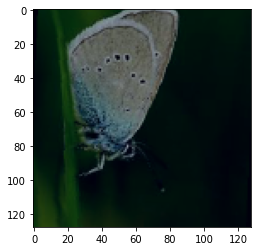

In [43]:
imshow_loader(train_data[1000][0])

In [44]:
### Model 클래스 정의 - 차원에 유의하자!
# 10개의 클래스를 분류해야 하는 꽤나 복잡한 task - 모델 구조를 어느 정도로 복잡하게 짜볼까?
# 가장 마지막 Linear의 out_features는 얼마로 해야할까?
import torch.nn as nn

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        
        ##### Layer 정의 #####
        self.layer = nn.Sequential(
            # 맨처음 RGB 채널 3개이므로 가장 처음 in_channels = 3
            # img의 가장 첫 차원이 batch_size 값은 계속해서 유지
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5),             # [batch_size,3,128,128] -> [batch_size,16,124,124] -> same with? - using 16 filters
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5),            # [batch_size,16,124,124] -> [batch_size,32,120,120]
            nn.ReLU(),
            nn.Dropout(0.2), # 0.2 확률로 Dropout
            nn.MaxPool2d(kernel_size=3, stride=3),                                # [batch_size,32,120,120] -> [batch_size,32,40,40]
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, padding=2), # [batch_size,32,40,40] -> [batch_size,32,39,39] 
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5),            # [batch_size,32,39,39] -> [batch_size,64,35,35]
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3),            # [batch_size,64,35,35] -> [batch_size,64,33,33]
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=2),            # [batch_size,64,33,33] -> [batch_size,64,32,32]
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.MaxPool2d(kernel_size=2, stride=2)                                 # [batch_size,64,16,16] -> [batch_size,64,16,16]
        )
        self.fc_layer = nn.Sequential(
            nn.Linear(64*16*16,100),                                                # [batch_size,64*16*16] -> [batch_size,100]
            nn.ReLU(),
            nn.Linear(100,10)
        )

    def forward(self, x):
        # forward pass 과정
        out = self.layer(x)
        out = out.view(out.size(0),-1)  # FC layer에 들어가기전, flatten! - view 함수 활용
                                        # 가장 첫 차원인 batch_size는 유지하고 나머지 차원들을 하나로 합치기 - [batch_size,16,5,5] -> [batch_size,16*5*5]
        out = self.fc_layer(out)
        return out

In [45]:
# Device 선언 (GPU 권장)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [46]:
# torchsummary로 모델 차원 어떻게 나오는지 돌려보기
from torchsummary import summary
test_model = MyModel().to(device) # 모델 객체 선언
summary(test_model, (3,128,128), batch_size=32)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [32, 16, 124, 124]           1,216
              ReLU-2         [32, 16, 124, 124]               0
            Conv2d-3         [32, 32, 120, 120]          12,832
              ReLU-4         [32, 32, 120, 120]               0
           Dropout-5         [32, 32, 120, 120]               0
         MaxPool2d-6           [32, 32, 40, 40]               0
            Conv2d-7           [32, 32, 40, 40]          25,632
              ReLU-8           [32, 32, 40, 40]               0
            Conv2d-9           [32, 64, 36, 36]          51,264
             ReLU-10           [32, 64, 36, 36]               0
           Conv2d-11           [32, 64, 34, 34]          36,928
             ReLU-12           [32, 64, 34, 34]               0
           Conv2d-13           [32, 64, 33, 33]          16,448
             ReLU-14           [32, 64,

In [47]:
# 모델 객체 선언
mymodel = MyModel().to(device)
mymodel

MyModel(
  (layer): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (3): ReLU()
    (4): Dropout(p=0.2, inplace=False)
    (5): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (7): ReLU()
    (8): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (9): ReLU()
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (11): ReLU()
    (12): Conv2d(64, 64, kernel_size=(2, 2), stride=(1, 1))
    (13): ReLU()
    (14): Dropout(p=0.2, inplace=False)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layer): Sequential(
    (0): Linear(in_features=16384, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=10, bias=True)
  )
)

In [48]:
# loss func, optimizer 정의
criterion = nn.CrossEntropyLoss().to(device) # criterion (loss func)도 device 위에서
optimizer = torch.optim.Adam(mymodel.parameters(), lr=0.001, weight_decay=0.0001)

In [49]:
# train 함수 정의
def train(epoch):
    print(f'\n[ Train epoch: {epoch+1} ]')

    mymodel.train() # train은 항상 이걸 지정하고 시작! - Dropout, Batch Normalization 등의 효과를 적용하고 진행하기 위함

    running_loss = 0.0
    batch_losses = []
    total = 0
    correct = 0

    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device) # dataloader의 input image와 label도 device에 넣어줘야됨
        
        # DL 학습 기본 코드
        optimizer.zero_grad() # gradient 초기화
        outputs = mymodel(inputs) # 현재 batch의 inputs을 모델에 넣어 outputs 추출 (확률값)
        loss = criterion(outputs, targets) # 추출한 outputs와 원래 label인 targets 사이 loss 계산
        loss.backward() # 계산한 loss 기반으로 gradient 값 계산
        optimizer.step() # weight parameter update

        total += targets.size(0) # batch 데이터 개수 더하기
        running_loss += loss.item()
        batch_losses.append(loss.item())
        
        _, predicted = outputs.max(1) # 확률값 가장 높게 나타난 클래스
        correct += (predicted == targets).sum().item() # 현재 batch 내에서 알맞게 분류한 이미지 개수 더하기
        
        if batch_idx % 100 == 99:
            print(f'\nCurrent batch: {str(batch_idx+1)}')
            print(f'Average train loss of recent 100 batches: {running_loss / 100}') # 이렇게 출력하는 것이 꼭 필요한 것은 아니지만, 중간중간 확인을 위해 매우 권장
            running_loss = 0.0

    avg_loss = sum(batch_losses) / len(batch_losses)
    seq_train_loss.append(avg_loss)
    seq_train_acc.append(100*correct/total)
    print('\nTotal train accuarcy:', 100. * correct / total) # 전체 데이터 개수에서 맞게 예측한 비율
    print('Total train loss:', avg_loss)

In [50]:
# test 함수 정의
def test(epoch):
    print(f'\n[ Test epoch: {epoch+1} ]')

    mymodel.eval() # eval은 항상 이걸 지정하고 시작! - Dropout, Batch Normalization 등의 효과를 적용하지 않기 위함!
                   # ex. evaluation 할때는 Dropout 없이 지금까지 학습한 모든 node를 활용해서 진행해야됨

    loss = 0
    batch_losses = []
    correct = 0
    total = 0

    with torch.no_grad(): # gradient update 안함 - eval과 torch.no_grad는 하나의 세트
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = mymodel(inputs)
            loss = criterion(outputs, targets)
            batch_losses.append(loss.item())

            total += targets.size(0)
            _, predicted = outputs.max(1)
            correct += (predicted == targets).sum().item()

    avg_loss = sum(batch_losses) / len(batch_losses)
    seq_test_loss.append(avg_loss)
    seq_test_acc.append(100 * correct / total)
    print('\nTest accuarcy:', 100. * correct / total)
    print('Test average loss:', avg_loss)

In [51]:
num_epoch = 50

In [52]:
seq_train_loss = []
seq_test_loss = []
seq_train_acc = []
seq_test_acc = []

In [53]:
# training
for epoch in range(0, num_epoch):
    train(epoch)
    test(epoch)

# model 저장! - parameter값 저장
torch.save(mymodel.state_dict(), './mymodel_cnnHW.pt')
print('Model Saved!')


[ Train epoch: 1 ]

Current batch: 100
Average train loss of recent 100 batches: 2.22284414768219

Current batch: 200
Average train loss of recent 100 batches: 2.115722143650055

Current batch: 300
Average train loss of recent 100 batches: 2.0274284863471985

Current batch: 400
Average train loss of recent 100 batches: 1.9947640466690064

Current batch: 500
Average train loss of recent 100 batches: 1.9517550098896026

Total train accuarcy: 26.553888130968623
Total train loss: 2.0573517481486

[ Test epoch: 1 ]

Test accuarcy: 32.45480010185893
Test average loss: 1.954919408007366

[ Train epoch: 2 ]

Current batch: 100
Average train loss of recent 100 batches: 1.9680685698986053

Current batch: 200
Average train loss of recent 100 batches: 1.9260993194580078

Current batch: 300
Average train loss of recent 100 batches: 1.8739146184921265

Current batch: 400
Average train loss of recent 100 batches: 1.8952337396144867

Current batch: 500
Average train loss of recent 100 batches: 1.8628

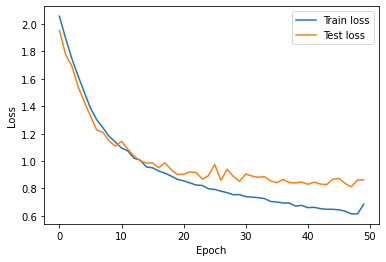

In [54]:
# loss, accuracy 추이 확인 with plt.plot
plt.plot(range(num_epoch), seq_train_loss, label="Train loss")
plt.plot(range(num_epoch), seq_test_loss, label="Test loss")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

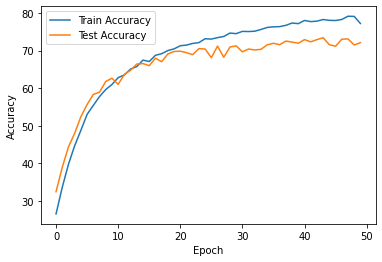

In [55]:
plt.plot(range(num_epoch), seq_train_acc, label="Train Accuracy")
plt.plot(range(num_epoch), seq_test_acc, label="Test Accuracy")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()